In [1]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask


plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [53]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
model_array_dir = [f'test{i}' for i in range(1,9)] # 1e-2, 1e-6, 1e-7

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    'reward': (2, [0]), 
    'action': (2, [0]), 
}

output_config = {
    'action': (3, [0]), # left, right, fixation
    'block_type': (2, [0]), # where or what block
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

loaded args


/scratch/f005d7d/ipykernel_840219/22185598.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'

<All keys matched successfully>
model at test1 loaded successfully
<All keys matched successfully>
model at test2 loaded successfully
<All keys matched successfully>
model at test3 loaded successfully
<All keys matched successfully>
model at test4 loaded successfully
<All keys matched successfully>
model at test5 loaded successfully
<All keys matched successfully>
model at test6 loaded successfully
<All keys matched successfully>
model at test7 loaded successfully
<All keys matched successfully>
model at test8 loaded successfully


In [ ]:
def test_model(model, epoch, test_samples=10):
    model.eval()

    results_dict = {
        'block_type': [], # num_blocks
        'stimulus': [], # num_blocks X num_trials
        'inputs': [], # num_blocks X num_trials X 2*num_dims
        'img_chosen': [], # num_blocks X num_trials
        'loc_chosen': [], # num_blocks X num_trials
        'reward': [], # num_blocks X num_trials
        'reward_probs': [], # num_blocks X num_trials X 2
        'neuron_states': [], # num_blocks X num_trials X num_timesteps X num_units
        'synaptic_states': [] # num_blocks X num_trials X num_units X num_units
    }

    with torch.no_grad():
        for test_block_type in range(2):
            for batch_idx in range(test_samples):
                trial_info = what_where_task.generate_trials(
                    batch_size = args['batch_size'],
                    trials_per_block = args['trials_per_test_block'], 
                    reversal_interval = [args['trials_per_test_block']//2-args['test_reversal_interval_range']//2, 
                                        args['trials_per_test_block']//2+args['test_reversal_interval_range']//2,],
                    reward_schedule=[args['reward_probs_high'], 1-args['reward_probs_high']],
                    block_type=test_block_type,
                ) 
                stim_inputs = trial_info['stim_inputs'].to(device, dtype=torch.float)
                rewards = trial_info['rewards'].to(device)
                
                hidden = None
                w_hidden = None

                results_dict['block_type'].append(test_block_type)
                results_dict['stimulus'].append(trial_info['stim_configs'])
                results_dict['inputs'].append(trial_info['stim_inputs'])
                results_dict['reward_probs'].append(trial_info['reward_probs'])

                results_dict['img_chosen'].append([])
                results_dict['loc_chosen'].append([])
                results_dict['reward'].append([])
                
                results_dict['neuron_states'].append([])
                results_dict['synaptic_states'].append([])
                
                for i in range(len(stim_inputs)):
                    results_dict['neuron_states'][-1].append([])
                    ''' first phase, give nothing '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_ITI, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    
                    ''' second phase, give fixation '''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_fixation, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' third phase, give stimuli and no feedback '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    output, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_stim, 
                                                        neumann_order=args['neumann_order'],
                                                        hidden=hidden, w_hidden=w_hidden, 
                                                        update_w=False, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' use output to calculate action, reward, and record loss function '''
                    action = torch.multinomial(output['action'][...,:2].softmax(-1), num_samples=1).squeeze(-1) # (batch size, )
                    rwd_ch = rewards[i][range(args['batch_size']),action] # (batch size, )
                    
                    results_dict['img_chosen'][-1].append((action!=trial_info['stim_configs']).astype(int))
                    # (loc_choice, config)->img_chosen, (0,0)->0, (1,0)->1, (0,1)->1, (1,1)->0
                    results_dict['loc_chosen'][-1].append(action)
                    results_dict['reward'][-1].append(rwd_ch)

                    '''fourth phase, give stimuli and choice, and update weights'''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.eye(2, device=device)[None][range(args['batch_size']), rwd_ch], # 2+2 for chosen and unchosen rewards
                        'action': torch.eye(2, device=device)[None][range(args['batch_size']), action], # left/right
                    }

                    output, hidden, w_hidden, hs = model(all_x, steps=what_where_task.T_choice, 
                                                    neumann_order=args['neumann_order'],
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    update_w=True, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    results_dict['synaptic_states'][-1].append(w_hidden)

                    results_dict['neuron_states'][-1][-1] = np.concatenate(results_dict['neuron_states'][-1][-1], axis=0) # num_timesteps, batch_size, num_dims

                # collect results in 
                results_dict['img_chosen'][-1] = np.array(results_dict['img_chosen'][-1]) # num_trials X batch_size
                results_dict['loc_chosen'][-1] = np.array(results_dict['loc_chosen'][-1]) # num_trials X batch_size 
                results_dict['reward'][-1] = np.array(results_dict['reward'][-1]) # num_trials X batch_size

                results_dict['neuron_states'][-1] = np.stack(results_dict['neuron_states'][-1]) # num_trials, num_timesteps, batch_size, num_dims
                results_dict['synaptic_states'][-1] = np.stack(results_dict['synaptic_states'][-1]) # num_trials X batch_size X num_dims X num_dims
        
            results_dict

        return results_dict

In [ ]:
def stay_probs(results_dict):
    # calculate the probability of staying with the same location and stimulus choice given previous trial's reward outcomes
    # results_dict: dict of results from the model
    # return: dict of stay probabilities

    num_blocks, num_trials = results_dict['reward'].shape
    stay_probs = {
        'what_unrewarded_loc': [],
        'what_rewarded_loc': [],
        'where_unrewarded_loc': [],
        'where_rewarded_loc': [],
        'what_unrewarded_img': [],
        'what_rewarded_img': [],
        'where_unrewarded_img': [],
        'where_rewarded_img': [],
    }

    for block_idx in range(num_blocks):
        block_type = results_dict['block_type'][block_idx]
        reward = results_dict['reward'][block_idx]
        img_chosen = results_dict['img_chosen'][block_idx]
        loc_chosen = results_dict['loc_chosen'][block_idx]

        reward_prev = np.isclose(reward[:-1], 1)
        unreward_prev = np.isclose(reward[:-1], 0)

        if block_type == 0:
            stay_probs['where_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['where_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['where_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['where_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
        elif block_type == 1:
            stay_probs['what_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['what_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['what_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['what_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
        else:
            raise ValueError

    return stay_probs

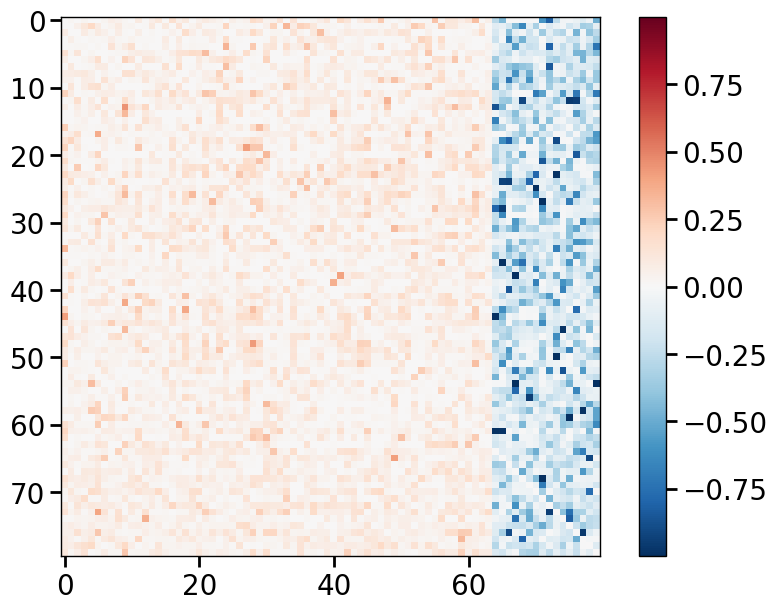

In [52]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].rnn.h2h.effective_weight().detach(), cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()


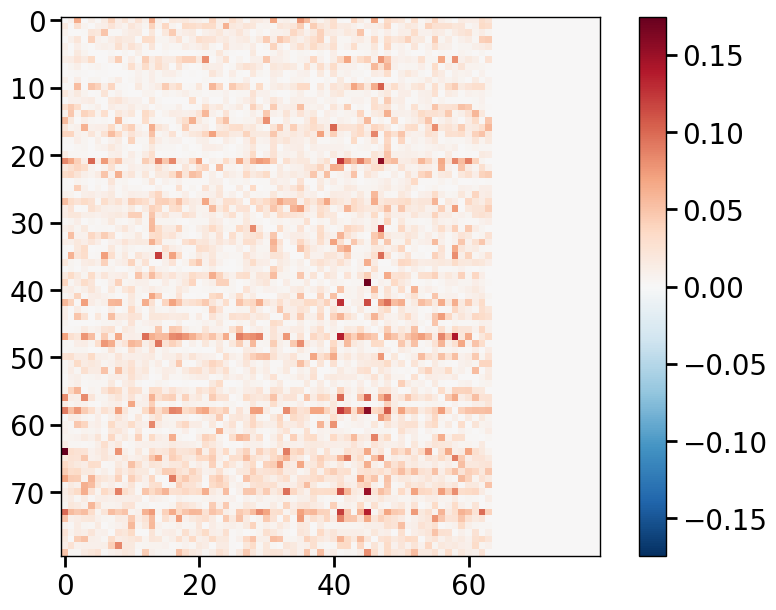

In [49]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].plasticity.effective_lr().detach(),  cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()

# Decomposition of input and output weights subspaces

The input weight is equal to $[I_{left, dim1}\ \ I_{left, dim2}\ \ I_{right, dim}\ \ I_{right, dim2}]$. We want to get $\bar{I}_{left}$, $\bar{I}_{right}$, $\bar{I}_{dim1}$, $\bar{I}_{dim2}$, as well as the residuals.

In [54]:
'''decompose the input weights'''

all_model_input_weights_raw = []

for mdl in all_models:
    all_model_input_weights_raw.append(mdl.rnn.x2h['stimulus'].effective_weight().detach())
    
all_model_input_weights_raw = torch.stack(all_model_input_weights_raw, dim=0).reshape(-1, args['hidden_size'], 4) # (num_models, hidden_size, 4)

# for the average stim representation, and the difference between the two locations
all_model_inputs_effective = all_model_input_weights_raw @ np.array([[1,-1,1,-1],
                                                                     [1,0,-1,0], 
                                                                     [0,1,0,-1]]).T[None] 

'''decompose the output weights'''

all_model_output_weights_raw = []

for mdl in all_models:
    all_model_output_weights_raw.append(mdl.h2o['action'].effective_weight().detach())
    
all_model_output_weights_raw = torch.stack(all_model_output_weights_raw, dim=0).reshape(-1, 3, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_outputs_effective = (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0])[...,None]

# all_model_outputs_effective = np.stack([
#     (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0]),
#     (all_model_output_weights_raw[:,:,2])], axis=-1)

'''decompose the action feedback weights'''

all_model_action_feedback_weights = []

for mdl in all_models:
    all_model_action_feedback_weights.append(mdl.rnn.x2h['action'].effective_weight().detach())
    
all_model_action_feedback_weights = torch.stack(all_model_action_feedback_weights, dim=0) # (num_models, hidden_size, 2)

all_model_action_feedback_weights_effective = (all_model_action_feedback_weights[:,:,1]-all_model_action_feedback_weights[:,:,0])[...,None]

'''decompose the reward weights'''
all_model_reward_weights = []
for mdl in all_models:
    all_model_reward_weights.append(mdl.rnn.x2h['reward'].effective_weight().detach())
all_model_reward_weights = torch.stack(all_model_reward_weights, dim=0) # (num_models, hidden_size, 2)
all_model_reward_weights_effective = (all_model_reward_weights[:,:,1]-all_model_reward_weights[:,:,0])[...,None]

'''decompose the fixation weights'''
all_model_fixation_weights = []
for mdl in all_models:
    all_model_fixation_weights.append(mdl.rnn.x2h['fixation'].effective_weight().detach())
all_model_fixation_weights = torch.stack(all_model_fixation_weights, dim=0) # (num_models, hidden_size, 1)

'''decompose the block type weights'''
all_model_block_type_weights = []
for mdl in all_models:
    all_model_block_type_weights.append(mdl.h2o['block_type'].effective_weight().detach().T)
all_model_block_type_weights = torch.stack(all_model_block_type_weights, dim=0) # (num_models, hidden_size, 2)
all_model_block_type_weights_effective = (all_model_block_type_weights[:,:,1]-all_model_block_type_weights[:,:,0])[...,None]



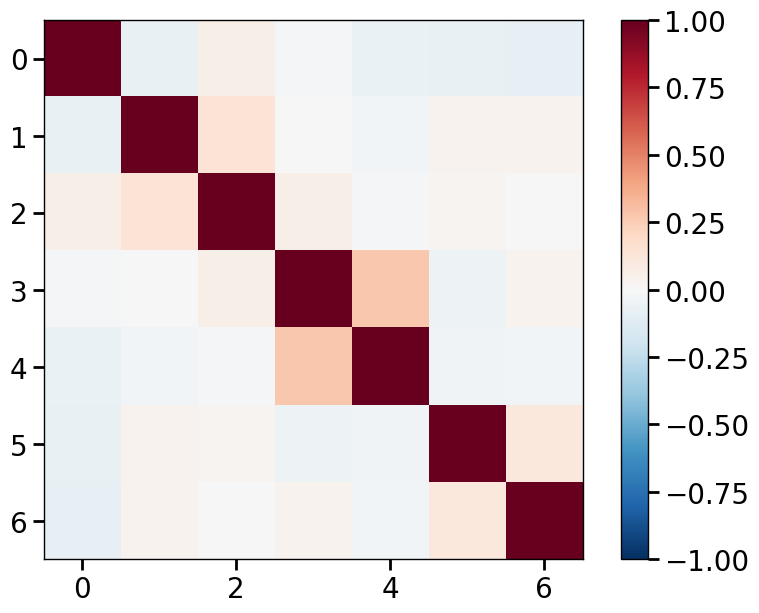

In [55]:
'''calculate the overlap between the bases'''
# ignoring the fixation related bases for now

all_model_bases = np.concatenate([all_model_inputs_effective, 
                                  all_model_outputs_effective, 
                                  all_model_action_feedback_weights_effective,
                                  all_model_reward_weights_effective,
                                  all_model_block_type_weights_effective], axis=-1) # (num_models, hidden_size, 3+1+1+1+1)

all_model_bases = all_model_bases / (np.linalg.norm(all_model_bases, axis=1, keepdims=True)+1e-10) 

plt.imshow(np.mean([all_model_bases[i].T@all_model_bases[i] for i in range(8)], 0), 
           cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

# Clustering of units into distinct populations

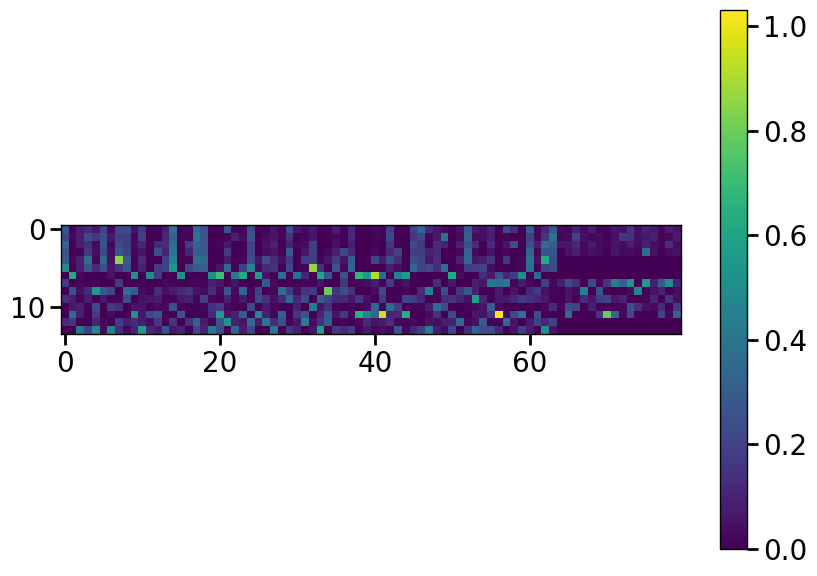

In [56]:
all_model_weights = np.concatenate([all_model_input_weights_raw, 
                                    all_model_output_weights_raw, 
                                    all_model_action_feedback_weights,
                                    all_model_reward_weights,
                                    all_model_fixation_weights,
                                    all_model_block_type_weights], axis=-1)

plt.imshow(all_model_weights[0].T)
plt.colorbar()




n_clusters=2, silhouette_score=0.524
n_clusters=3, silhouette_score=0.484
n_clusters=4, silhouette_score=0.466
n_clusters=5, silhouette_score=0.433
n_clusters=6, silhouette_score=0.380
n_clusters=7, silhouette_score=0.287
n_clusters=8, silhouette_score=0.259
n_clusters=9, silhouette_score=0.243
n_clusters=10, silhouette_score=0.255


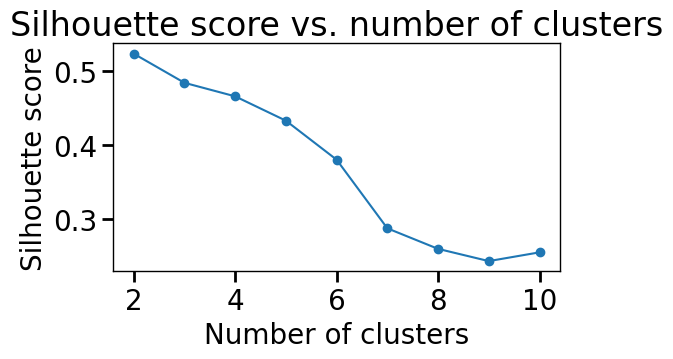

In [57]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# all_model_weights: shape (num_models, hidden_size, num_features)
# Concatenate all hidden units from all models: (num_models * hidden_size, num_features)
all_units = all_model_weights[:,:64].reshape(-1, all_model_weights.shape[-1])

silhouette_scores = []
cluster_range = range(2, 11)  # Try 2 to 10 clusters

for n_clusters in cluster_range:
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='cosine', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
    labels = clustering.fit_predict(all_units)
    score = silhouette_score(all_units, labels, metric='cosine')
    silhouette_scores.append(score)
    print(f"n_clusters={n_clusters}, silhouette_score={score:.3f}")

plt.figure(figsize=(6,4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs. number of clusters")
plt.tight_layout()
plt.show()



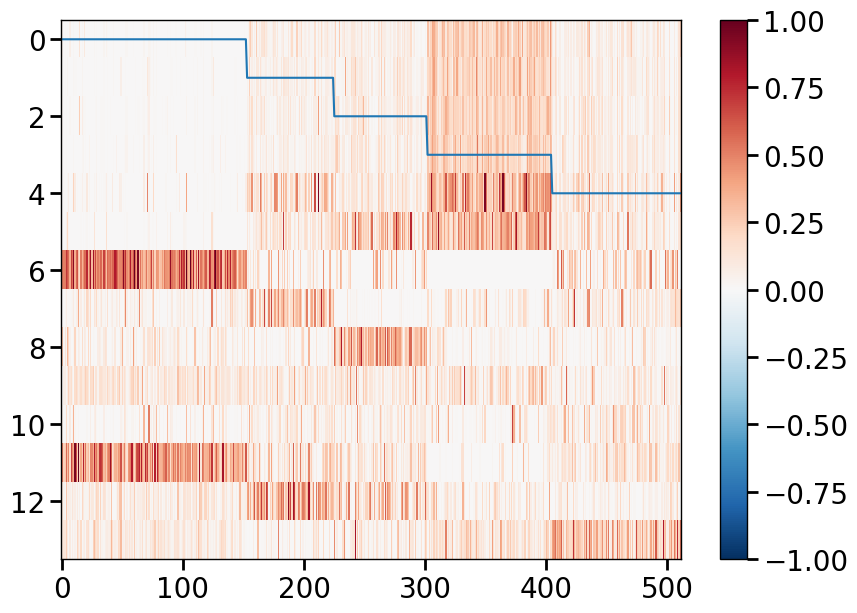

In [58]:
# Let's use the best number of clusters (highest silhouette score)
best_n_clusters = 5
clustering = SpectralClustering(n_clusters=best_n_clusters, affinity='rbf', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
labels = clustering.fit_predict(all_units)

# Calculate centroids
centroids = np.concatenate([all_units[labels == k] for k in range(best_n_clusters)], axis=0)


plt.imshow(centroids.T, aspect='auto', cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=1))
plt.plot(np.sort(labels))
plt.colorbar()
plt.show()


# Transformatin of bases by recurrent weights

In [59]:
'''get all model's recurrent weights'''

all_model_recurrent_weights = []
for mdl in all_models:
    all_model_recurrent_weights.append(mdl.rnn.h2h.effective_weight().detach())
all_model_recurrent_weights = torch.stack(all_model_recurrent_weights, dim=0)  # (num_models, hidden_size, hidden_size)


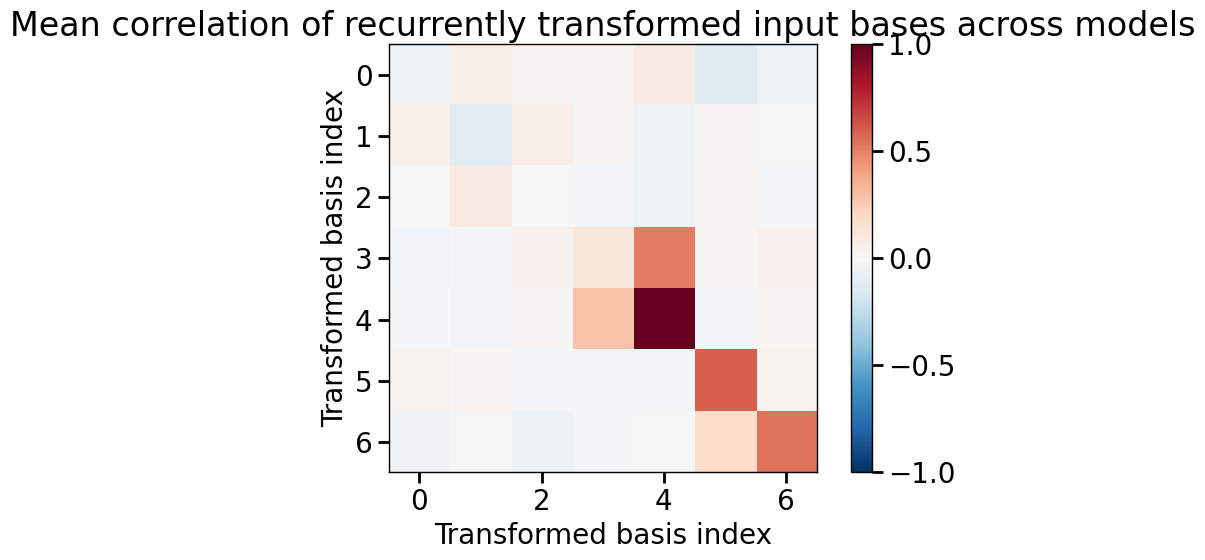

In [60]:
# Visualize how the recurrent weight transforms the input bases by performing a matrix change of variable
# For each model, transform the input bases by its recurrent weight, then average the resulting correlation matrices

num_models = all_model_recurrent_weights.shape[0]
num_bases = all_model_bases.shape[-1]

corrs = []
for i in range(num_models):
    W_rec = all_model_recurrent_weights[i].numpy()  # (hidden_size, hidden_size)
    input_bases = all_model_bases[i]  # (hidden_size, num_bases)
    transformed_bases = W_rec @ input_bases  # (hidden_size, num_bases)
    # transformed_bases = transformed_bases / np.linalg.norm(transformed_bases, axis=0, keepdims=True)
    corr = input_bases.T @ transformed_bases # (num_bases, num_bases)
    corrs.append(corr)

mean_corr = np.mean(corrs, axis=0)
plt.figure(figsize=(8,6))
plt.imshow(mean_corr, cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0, halfrange=1))
plt.colorbar()
plt.title("Mean correlation of recurrently transformed input bases across models")
plt.xlabel("Transformed basis index")
plt.ylabel("Transformed basis index")

plt.tight_layout()

plt.show()



# Encoding and recall of the stim and action subspaces by plasticity

In [28]:
all_model_learning_rates = []
for mdl in all_models:
    all_model_learning_rates.append(mdl.plasticity.effective_lr())
all_model_learning_rates = torch.stack(all_model_learning_rates, dim=0)  # (num_models, hidden_size, hidden_size)

In [ ]:
# all_model_bases = np.concatenate([all_model_inputs_effective, 
#                                   all_model_outputs_effective, 
#                                   all_model_action_feedback_weights_effective,
#                                   all_model_reward_weights_effective,
#                                   all_model_block_type_weights_effective], axis=-1) # (num_models, hidden_size, 3+1+1+1+1)

In [ ]:
from itertools import product

for (i, j, k, l) in product(range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1])):
    print(i, j, k, l)








    

0 0 0 0
0 0 0 1
0 0 0 2
0 0 0 3
0 0 0 4
0 0 0 5
0 0 0 6
0 0 1 0
0 0 1 1
0 0 1 2
0 0 1 3
0 0 1 4
0 0 1 5
0 0 1 6
0 0 2 0
0 0 2 1
0 0 2 2
0 0 2 3
0 0 2 4
0 0 2 5
0 0 2 6
0 0 3 0
0 0 3 1
0 0 3 2
0 0 3 3
0 0 3 4
0 0 3 5
0 0 3 6
0 0 4 0
0 0 4 1
0 0 4 2
0 0 4 3
0 0 4 4
0 0 4 5
0 0 4 6
0 0 5 0
0 0 5 1
0 0 5 2
0 0 5 3
0 0 5 4
0 0 5 5
0 0 5 6
0 0 6 0
0 0 6 1
0 0 6 2
0 0 6 3
0 0 6 4
0 0 6 5
0 0 6 6
0 1 0 0
0 1 0 1
0 1 0 2
0 1 0 3
0 1 0 4
0 1 0 5
0 1 0 6
0 1 1 0
0 1 1 1
0 1 1 2
0 1 1 3
0 1 1 4
0 1 1 5
0 1 1 6
0 1 2 0
0 1 2 1
0 1 2 2
0 1 2 3
0 1 2 4
0 1 2 5
0 1 2 6
0 1 3 0
0 1 3 1
0 1 3 2
0 1 3 3
0 1 3 4
0 1 3 5
0 1 3 6
0 1 4 0
0 1 4 1
0 1 4 2
0 1 4 3
0 1 4 4
0 1 4 5
0 1 4 6
0 1 5 0
0 1 5 1
0 1 5 2
0 1 5 3
0 1 5 4
0 1 5 5
0 1 5 6
0 1 6 0
0 1 6 1
0 1 6 2
0 1 6 3
0 1 6 4
0 1 6 5
0 1 6 6
0 2 0 0
0 2 0 1
0 2 0 2
0 2 0 3
0 2 0 4
0 2 0 5
0 2 0 6
0 2 1 0
0 2 1 1
0 2 1 2
0 2 1 3
0 2 1 4
0 2 1 5
0 2 1 6
0 2 2 0
0 2 2 1
0 2 2 2
0 2 2 3
0 2 2 4
0 2 2 5
0 2 2 6
0 2 3 0
0 2 3 1
0 2 3 2
0 2 3 3
0 2 3 4
0 2 3 5
